In [4]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
train_df = pd.read_csv("./generated-or-not/train.csv")
test_df = pd.read_csv("./generated-or-not/test.csv")
img_count = len(os.listdir('./generated-or-not/images/'))
print(f"Кол-во картинок всего: {img_count}\n\n")

print("train info: \n",train_df.head())
print("\n\ntest info: \n",test_df.head())

Кол-во картинок всего: 1518


train info: 
                 id  target
0   gL5fWrgNPU.jpg       0
1   KKWXJDN8uM.png       1
2   Wb2I0CXlAY.jpg       0
3  G7PLhKpaf7.jpeg       1
4   DEUkeefz6Z.jpg       0


test info: 
                 id
0  Qt1fGUB0Vz.jpeg
1  j4Rhioq7R3.jpeg
2  rD0hgFHJUZ.jpeg
3  aY5z1EJsJ6.jpeg
4  qZ3IoxD2TE.jpeg


In [5]:
from matplotlib import image as mpimg
import os
import random


def look_on_(source_type : int = 1):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))
    gen = list(train_df[train_df['target'] == source_type]['id'])
    
    random.shuffle(gen)
    img_names = os.listdir('./generated-or-not/images/')
    
    for (i, ax), g in zip(enumerate(axes.flat), gen):    
        img_ = [img for img in img_names if img.split('.')[0] == g.split('.')[0]]
        path = f'./generated-or-not/images/{img_[0]}'
        ax.imshow(mpimg.imread(path))
        ax.set_axis_off()
        
    plt.suptitle(f'{"Сгенерированные" if source_type else "Реальные"} картинки')
    

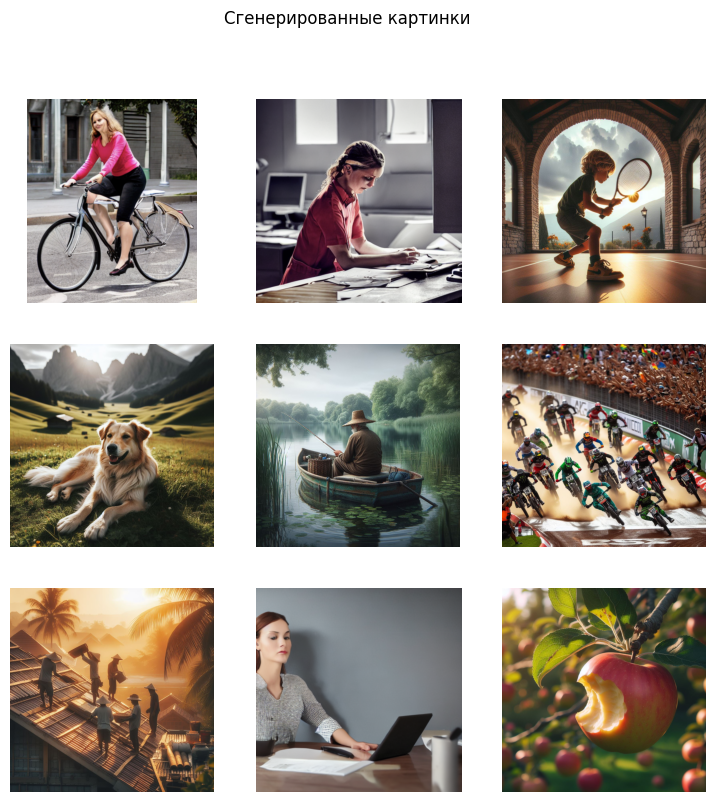

In [6]:
look_on_(1)

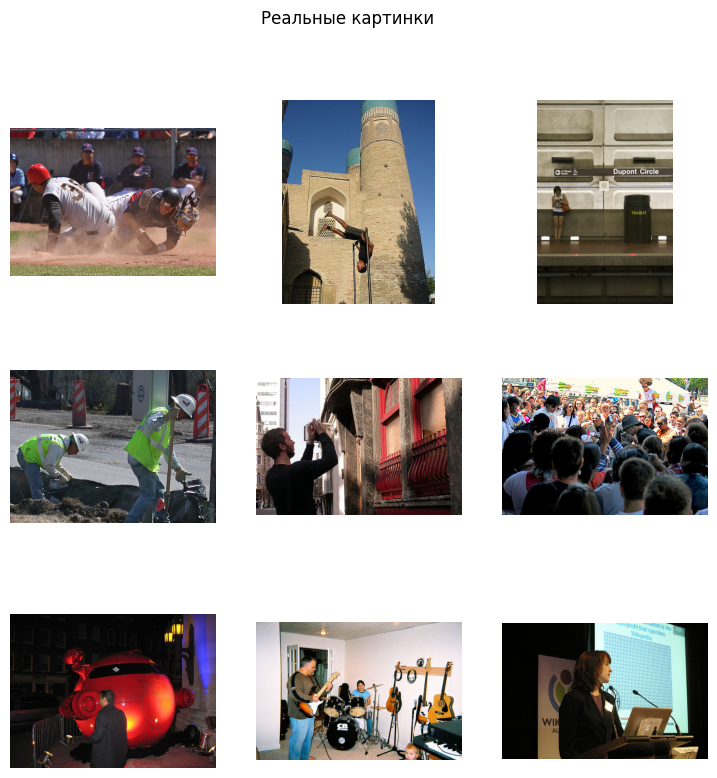

In [7]:
look_on_(0)

* Так как некоторые названия файлов в датасете без расширения - можно их восстановить.

In [8]:
img_names = os.listdir('./generated-or-not/images/')
repaired_train_df = pd.DataFrame(columns=['id', 'target'])
repaired_test_df = pd.DataFrame(columns=['id'])

for rep_df, chosen_df in zip([repaired_train_df, repaired_test_df], [train_df, test_df]):
    for row in chosen_df.itertuples():
        name_ext = row.id.split('.')
        img_name_ = [img_name for img_name in img_names if img_name.split('.')[0] == name_ext[0]][0]
        ins_val = [img_name_, row.target] if 'target' in chosen_df else [img_name_]
        rep_df.loc[len(rep_df)] = ins_val


In [9]:
print(repaired_train_df.head())
print(repaired_test_df.head())


                id  target
0   gL5fWrgNPU.jpg       0
1   KKWXJDN8uM.png       1
2   Wb2I0CXlAY.jpg       0
3  G7PLhKpaf7.jpeg       1
4   DEUkeefz6Z.jpg       0
                id
0  Qt1fGUB0Vz.jpeg
1  j4Rhioq7R3.jpeg
2  rD0hgFHJUZ.jpeg
3  aY5z1EJsJ6.jpeg
4  qZ3IoxD2TE.jpeg


* проверим отличия

In [10]:
# Объединение DataFrame с помощью merge с указанием индикатора
merged = pd.merge(repaired_train_df, train_df, how='outer', indicator=True)

# Фильтрация строк, которые есть только в одном из DataFrame
differences = merged[merged['_merge'] != 'both']

# Вывод отличающихся строк
print("Отличающиеся строки:")
print(differences)

Отличающиеся строки:
                  id  target      _merge
6     hG9nlBfDeh.png       1   left_only
22    Evdusx0Cel.png       1   left_only
23    jsCvbsKj7U.png       1   left_only
27    up31h8HYKk.png       1   left_only
28    8mtNcVjofj.png       1   left_only
...              ...     ...         ...
1173      NYOMKoX0pw       1  right_only
1174      mKbuw6UZuK       1  right_only
1175      5WU9zzvTQA       1  right_only
1176      fqoVycdxLV       1  right_only
1177      Q9JbpjHZVU       1  right_only

[332 rows x 3 columns]


* названия картинок починены, сохраню в новые csv

In [11]:
repaired_train_df.to_csv('./generated-or-not/fix_train.csv')
repaired_test_df.to_csv('./generated-or-not/fix_test.csv')


#### 1) Для начала посмотрю на гистограммы цветовых распределений картинок

In [34]:
import cv2

def picture_color_hist(source_type: int = 1):
    # Загрузка изображений
    images_names_of_type_ = repaired_train_df[repaired_train_df['target'] == source_type]['id']
    images_of_type_ = [cv2.imread(f'./generated-or-not/images/{img_name}') for img_name in images_names_of_type_]

    # Объединение всех каналов цвета изображений
    all_channels = [image.flatten() for image in images_of_type_]
    all_channels = np.concatenate(all_channels)
    # Построение общей гистограммы для всех каналов
    hist1 = cv2.calcHist([all_channels], [0], None, [256], [0,256])
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # Отображение гистограммы
    axes[0].plot(hist1)
    axes[0].set_title(f'Комбинированная гистограмма {"Сгенерированных" if source_type == 1 else "Реальных"} изображений')
    axes[0].set_xlabel('Яркость')
    axes[0].set_ylabel('Частота')

    
    # Построение общей гистограммы для каждого канала цвета (красный, зелёный, синий)
    colors = ('r','g','b')
    for i, col in enumerate(colors):
        col_vals = [image[:,:,i].flatten() for image in images_of_type_]
        hist = cv2.calcHist(col_vals, [0], None, [256], [0,256])
        axes[1].plot(hist, color=col, label=col)
        axes[1].set_xlim([0,256])
    
    axes[1].set_title(f'Поканальная гистограмма {"Сгенерированных" if source_type == 1 else "Реальных"} изображений')
    axes[1].set_xlabel('Яркость')
    axes[1].set_ylabel('Частота')
    
    plt.tight_layout()
    plt.show()
    

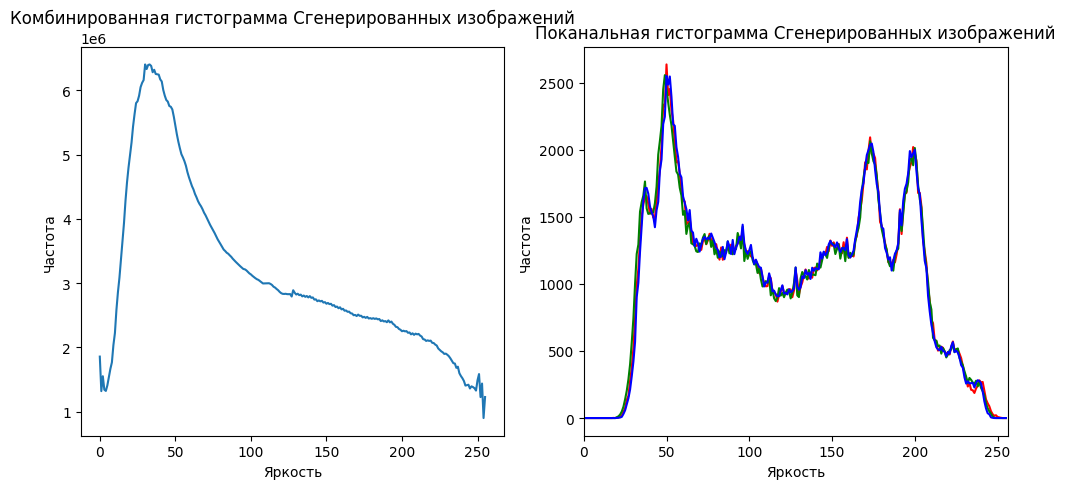

In [35]:
picture_color_hist(1)

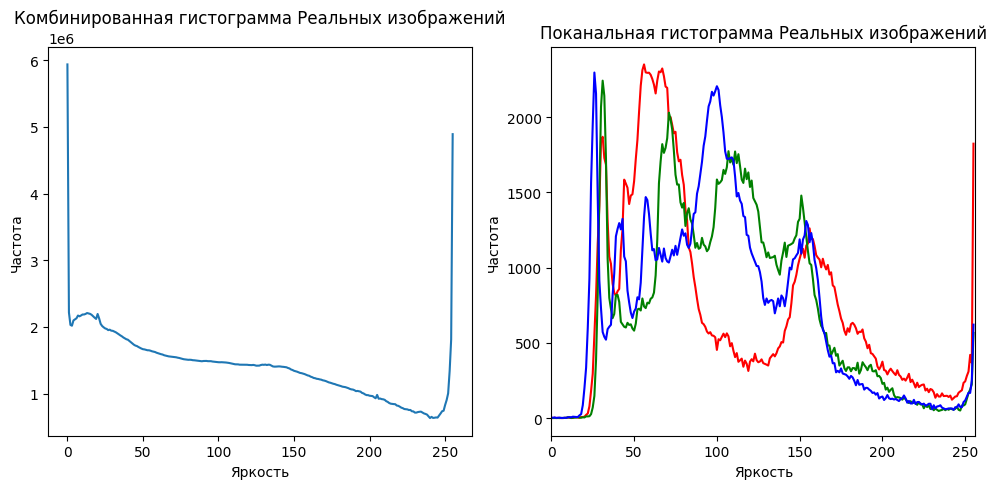

In [31]:
picture_color_hist(0)

* можно заметить, что 